This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

In [4]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-12-09 14:54:15--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.211.232, 52.217.75.62, 54.231.194.152, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.211.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: 'jena_climate_2009_2016.csv.zip.1'

     0K .......... .......... .......... .......... ..........  0%  256K 52s
    50K .......... .......... .......... .......... ..........  0%  262K 51s
   100K .......... .......... .......... .......... ..........  1% 12.5M 34s
   150K .......... .......... .......... .......... ..........  1%  261K 38s
   200K .......... .......... .......... .......... ..........  1% 27.9M 30s
   250K .......... .......... .......... .......... ..........  2% 36.4M 25s
   300K .......... .......... .......... .......... ..........  2%  434K 26s
   350K .......... .......... .......... ......

'unzip' 不是內部或外部命令、可執行的程式或批次檔。


**Inspecting the data of the Jena weather dataset**

In [6]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [7]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

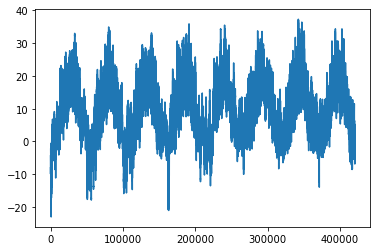

In [8]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

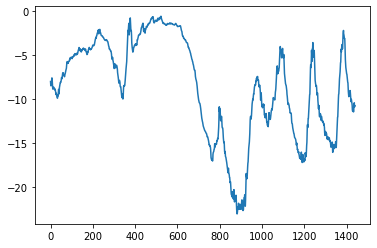

In [9]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [10]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [11]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [12]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [13]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [14]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [15]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [16]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 9s 9ms/step - loss: 13.1383 - mae: 2.7911 - val_loss: 11.0932 - val_mae: 2.6279
Epoch 2/10
819/819 [==============================] - 7s 9ms/step - loss: 8.7863 - mae: 2.3265 - val_loss: 11.5993 - val_mae: 2.7045
Epoch 3/10
819/819 [==============================] - 7s 9ms/step - loss: 8.0529 - mae: 2.2296 - val_loss: 12.9234 - val_mae: 2.8465
Epoch 4/10
819/819 [==============================] - 7s 9ms/step - loss: 7.6025 - mae: 2.1673 - val_loss: 13.4523 - val_mae: 2.9220
Epoch 5/10
819/819 [==============================] - 7s 9ms/step - loss: 7.3135 - mae: 2.1263 - val_loss: 11.6978 - val_mae: 2.7017
Epoch 6/10
819/819 [==============================] - 7s 9ms/step - loss: 7.0888 - mae: 2.0950 - val_loss: 12.1153 - val_mae: 2.7638
Epoch 7/10
819/819 [==============================] - 7s 9ms/step - loss: 6.8782 - mae: 2.0632 - val_loss: 10.3748 - val_mae: 2.5385
Epoch 8/10
819/819 [==============================] - 8s 9ms/step - 

**Plotting results**

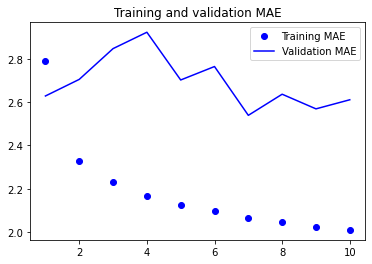

In [17]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [18]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 21s 25ms/step - loss: 21.0503 - mae: 3.6094 - val_loss: 15.2092 - val_mae: 3.0879
Epoch 2/10
819/819 [==============================] - 20s 25ms/step - loss: 15.2363 - mae: 3.0872 - val_loss: 14.9726 - val_mae: 3.0790
Epoch 3/10
819/819 [==============================] - 19s 23ms/step - loss: 13.7833 - mae: 2.9315 - val_loss: 15.6436 - val_mae: 3.1275
Epoch 4/10
819/819 [==============================] - 21s 25ms/step - loss: 12.9218 - mae: 2.8385 - val_loss: 19.0194 - val_mae: 3.4973
Epoch 5/10
819/819 [==============================] - 20s 24ms/step - loss: 12.3205 - mae: 2.7719 - val_loss: 16.3441 - val_mae: 3.1898
Epoch 6/10
819/819 [==============================] - 19s 23ms/step - loss: 11.8452 - mae: 2.7179 - val_loss: 15.1993 - val_mae: 3.0737
Epoch 7/10
819/819 [==============================] - 19s 24ms/step - loss: 11.4511 - mae: 2.6742 - val_loss: 16.8996 - val_mae: 3.2673
Epoch 8/10
819/819 [============================

### A first recurrent baseline

**A simple LSTM-based model**

In [19]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 33s 37ms/step - loss: 44.4447 - mae: 4.8714 - val_loss: 13.1387 - val_mae: 2.7384
Epoch 2/10
819/819 [==============================] - 30s 37ms/step - loss: 11.1040 - mae: 2.5930 - val_loss: 9.5429 - val_mae: 2.3982
Epoch 3/10
819/819 [==============================] - 30s 37ms/step - loss: 9.8629 - mae: 2.4505 - val_loss: 9.5476 - val_mae: 2.4081
Epoch 4/10
819/819 [==============================] - 32s 39ms/step - loss: 9.4318 - mae: 2.3902 - val_loss: 9.5233 - val_mae: 2.3980
Epoch 5/10
819/819 [==============================] - 31s 37ms/step - loss: 9.0225 - mae: 2.3388 - val_loss: 9.5029 - val_mae: 2.3989
Epoch 6/10
819/819 [==============================] - 31s 38ms/step - loss: 8.7393 - mae: 2.3015 - val_loss: 9.5181 - val_mae: 2.4002
Epoch 7/10
819/819 [==============================] - 33s 40ms/step - loss: 8.5078 - mae: 2.2715 - val_loss: 9.8690 - val_mae: 2.4530
Epoch 8/10
819/819 [==============================] - 33s 4

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [20]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [21]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [22]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [23]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [24]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 80s 94ms/step - loss: 30.0134 - mae: 4.0286 - val_loss: 9.7970 - val_mae: 2.4257
Epoch 2/50
819/819 [==============================] - 79s 96ms/step - loss: 14.8198 - mae: 2.9888 - val_loss: 9.7428 - val_mae: 2.4248
Epoch 3/50
819/819 [==============================] - 80s 98ms/step - loss: 13.8017 - mae: 2.8820 - val_loss: 9.0706 - val_mae: 2.3281
Epoch 4/50
819/819 [==============================] - 82s 100ms/step - loss: 13.1881 - mae: 2.8143 - val_loss: 9.1377 - val_mae: 2.3403
Epoch 5/50
819/819 [==============================] - 82s 100ms/step - loss: 12.7761 - mae: 2.7717 - val_loss: 9.3855 - val_mae: 2.3891
Epoch 6/50
819/819 [==============================] - 81s 99ms/step - loss: 12.4381 - mae: 2.7348 - val_loss: 9.1248 - val_mae: 2.3539
Epoch 7/50
819/819 [==============================] - 81s 99ms/step - loss: 12.0771 - mae: 2.6923 - val_loss: 9.3266 - val_mae: 2.3774
Epoch 8/50
819/819 [==============================] -

In [26]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [27]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 171s 203ms/step - loss: 24.9209 - mae: 3.6916 - val_loss: 9.2356 - val_mae: 2.3477
Epoch 2/50
819/819 [==============================] - 169s 206ms/step - loss: 14.0012 - mae: 2.8982 - val_loss: 9.0346 - val_mae: 2.3286
Epoch 3/50
819/819 [==============================] - 194s 237ms/step - loss: 13.1678 - mae: 2.8148 - val_loss: 9.1332 - val_mae: 2.3478
Epoch 4/50
819/819 [==============================] - 190s 232ms/step - loss: 12.6307 - mae: 2.7566 - val_loss: 8.8007 - val_mae: 2.2982
Epoch 5/50
819/819 [==============================] - 202s 247ms/step - loss: 12.1246 - mae: 2.7047 - val_loss: 9.8623 - val_mae: 2.4325
Epoch 6/50
819/819 [==============================] - 201s 246ms/step - loss: 11.7322 - mae: 2.6599 - val_loss: 9.3067 - val_mae: 2.3644
Epoch 7/50
819/819 [==============================] - 205s 250ms/step - loss: 11.4495 - mae: 2.6273 - val_loss: 8.9503 - val_mae: 2.3107
Epoch 8/50
819/819 [=====================

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [28]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 53s 60ms/step - loss: 31.9004 - mae: 4.0641 - val_loss: 11.4205 - val_mae: 2.6139
Epoch 2/10
819/819 [==============================] - 47s 58ms/step - loss: 10.0218 - mae: 2.4738 - val_loss: 9.7955 - val_mae: 2.4183
Epoch 3/10
819/819 [==============================] - 46s 56ms/step - loss: 9.0063 - mae: 2.3446 - val_loss: 9.5622 - val_mae: 2.3840
Epoch 4/10
819/819 [==============================] - 46s 56ms/step - loss: 8.5133 - mae: 2.2834 - val_loss: 9.7194 - val_mae: 2.3992
Epoch 5/10
819/819 [==============================] - 47s 58ms/step - loss: 8.0614 - mae: 2.2195 - val_loss: 9.8495 - val_mae: 2.4147
Epoch 6/10
819/819 [==============================] - 47s 57ms/step - loss: 7.6380 - mae: 2.1561 - val_loss: 9.8655 - val_mae: 2.4286
Epoch 7/10
819/819 [==============================] - 48s 59ms/step - loss: 7.3053 - mae: 2.1048 - val_loss: 10.3656 - val_mae: 2.4875
Epoch 8/10
819/819 [==============================] - 48s 

### Going even further

## Summary